# Project Notebook

### Imports

In [1]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Add, Input
from keras.models import Model
from tensorflow.nn import depth_to_space
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from PIL import Image
import math
from scipy.signal import convolve2d

2022-05-02 18:28:07.627481: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-02 18:28:07.627587: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from utils import *
from SRCNN import *
from DIPCI import *

### Data Processing

In [3]:
PATH_DATA = "./Data"

In [4]:
data_ssh = PATH_DATA+"/1308_square_NATL60_SSH_R09.npy"
data_sst = PATH_DATA+"/1308_square_NATL60_SST_R09.npy"
ssh = np.load(data_ssh)
sst = np.load(data_sst)
SSHMIN = ssh.min()
SSHMAX = ssh.max()

In [5]:
ssh_norm = np.array([normalize(img,0,1) for img in ssh])
sst_norm = np.array([normalize(img,0,1) for img in sst])

In [6]:
upscale_factor = 2

In [7]:
ssh_lr = np.array([downsample(img, upscale_factor) for img in ssh_norm])

### SRCNN + SubPixel

In [8]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "./tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

callbacks = [early_stopping_callback, model_checkpoint_callback]
srcnn = get_model(upscale_factor=upscale_factor, channels=1)
srcnn.summary()
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    1664      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 4)     1156      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 1)    0         
 ambda)                                                          
                                                             

2022-05-02 18:28:14.103506: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-02 18:28:14.103541: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-02 18:28:14.103563: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3800411-Latitude-E7270): /proc/driver/nvidia/version does not exist
2022-05-02 18:28:14.103769: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
epochs = 100
srcnn.compile(
    optimizer=optimizer, loss=loss_fn, metrics=['mse', PSNR]
)

Training (to skip)

In [10]:
batch_size = 8

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((ssh_lr[0:366], ssh_norm[0:366]))
train_ds = train_ds.batch(batch_size)

history = srcnn.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=(ssh_lr[366:],ssh_norm[366:]), verbose=1
)

srcnn.save('tmp/model/srcnn')

In [ ]:
plt.plot(history.history['mse'][10:])
plt.figure()
plt.plot(history.history['psnr'])

Results

In [ ]:
srcnn.load_weights(checkpoint_filepath)

In [ ]:
test_srcnn(srcnn, ssh_lr[366:], ssh[366:])

### Model

In [9]:
loss = keras.losses.MeanSquaredError()

optimizer = keras.optimizers.Adam(learning_rate=0.001)

checkpoint_filepath = "./tmp/checkpoint_dipci"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

callbacks = [early_stopping_callback, model_checkpoint_callback]

In [10]:
dipci = net()
dipci.compile(optimizer=optimizer, loss=loss, metrics=['mse', PSNR])
dipci.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lr_input (InputLayer)          [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 hr_input (InputLayer)          [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 model_3 (Functional)           (None, None, None,   833         ['lr_input[0][0]']               
                                1)                                                          

### Training (to skip)

In [ ]:
history = dipci.fit(
    x = {"lr_input": ssh_lr[0:366], "hr_input": sst_norm[0:366]},
    y=ssh_norm[0:366], 
    epochs=epochs, 
    callbacks=callbacks, 
    validation_data= { "lr_input": ssh_norm[366:0], "hr_input": sst_norm[366:0] },
    verbose=1
)

### Results

In [11]:
dipci.load_weights(checkpoint_filepath)

Average bicubic PSNR :  42.80161505700477
Average bicubic RMSE :  0.007395597532916707
Average DIPCI PSNR :  34.41723598728302
Average DIPCI RMSE :  0.018942381436739306


<Figure size 432x288 with 0 Axes>

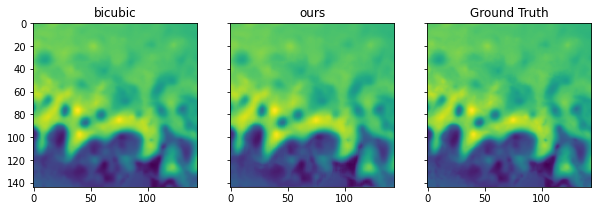

PSNR of Bicubic and Ground Truth image is  42.055525630331076
PSNR of DIPCI and Ground Truth is  34.37441546689617


<Figure size 432x288 with 0 Axes>

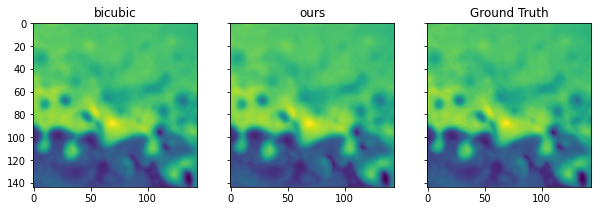

PSNR of Bicubic and Ground Truth image is  41.07153139241561
PSNR of DIPCI and Ground Truth is  34.15939907324925


<Figure size 432x288 with 0 Axes>

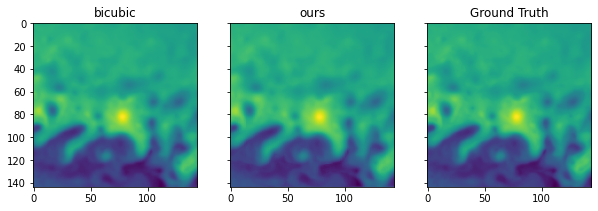

PSNR of Bicubic and Ground Truth image is  46.00044136447205
PSNR of DIPCI and Ground Truth is  35.345813880026384


<Figure size 432x288 with 0 Axes>

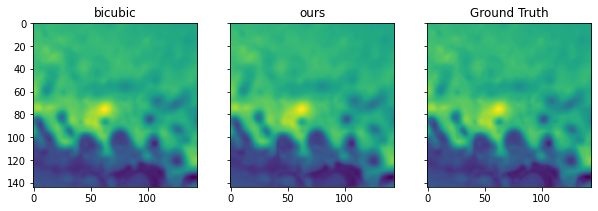

PSNR of Bicubic and Ground Truth image is  44.58536271859073
PSNR of DIPCI and Ground Truth is  36.5128007101778


<Figure size 432x288 with 0 Axes>

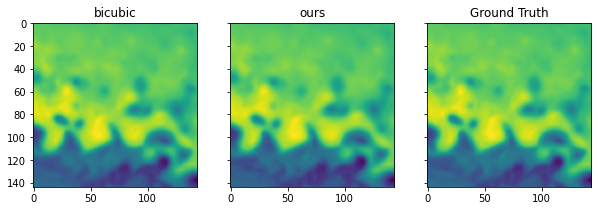

PSNR of Bicubic and Ground Truth image is  39.443042727213076
PSNR of DIPCI and Ground Truth is  29.988699939443777


In [12]:
test_dipci(dipci, ssh_lr[366:], sst_norm[366:], ssh[366:])